In [1]:
import os
import datetime

from pyonset import Onset, BootstrapWindow, OnsetStatsArray

# Import to enable the SEPPY drop-down menu
import seppy.tools.widgets as w

### Pyonset natively support all SEPpy-supported missions, which are:

> Parker Solar Probe (PSP)

> SOHO

> Solar Orbiter

> STEREO-A

> STEREO-B

> Wind

#### For this demonstration, we will choose from the drop-down menu the following options
> Spacecraft: SOHO

> Sensor: ERNE-HED

> Viewing: None

> Species: protons

This tutorial will cover how to find the onset time of an SEP event in one and more energy channels, how to produce figures showing the onset time, and finally how to apply velocity dispersion analysis (VDA) to the onset times as a function of energy to estimate the length of the path that the particles travelled, and the common injection time of the particles.

In [2]:
display(w.spacecraft_drop, w.sensor_drop, w.view_drop, w.species_drop)

Dropdown(description='Spacecraft:', options=('PSP', 'SOHO', 'Solar Orbiter', 'STEREO-A', 'STEREO-B', 'Wind'), …

Dropdown(description='Sensor:', options=('isois-epihi', 'isois-epilo'), value='isois-epihi')

Dropdown(description='Viewing:', options=('A', 'B'), value='A')

Dropdown(description='Species:', options=('protons', 'electrons'), value='protons')

In [3]:
# Values hard-coded here for the sake of example.
# Feel free to ignore this cell in favor of the drop-down menu.
w.spacecraft_drop.value = "SOHO"
w.sensor_drop.value = "ERNE-HED"
w.view_drop.value = None
w.species_drop.value = "protons"

# The workflow for finding the onset time and accompanying uncertainty:

>1.) Initialize the `Onset` object with `spacecraft`, `sensor`, possible `viewing` and particle `species`. Also provide the `startdate` and `enddate`, to load the desired data in to the object.

>2.) Identify the background preceding the event by setting the `start` and `end` parameters for the `BootstrapWindow` object as pandas-compatible datetime strings. Then run `cusum_onset()` to check that the an onset is found and that the background is reasonable. This may require multiple tries. Also set the amount of `bootstrap` iterations to this object, which controls the amount of random samples that are taken from the background window.

>4.) Set the `sample_size` to the fraction of the data points that should be taken for each of the random samples of the bootstrapping runs. Generally, the longer the background window, the smaller you may set the sample_size while still preserving good statistics. 

>4.) Run `onset_statistics_per_channel()` -method for the object. With (a) given channel(s) this will take random samples from the background and find a corresponding distribution of onset times. The width of the ~68 % confidence interval of this distribution in minutes, $\Delta \lfloor u_{1}^{1} \rfloor$, is the time resolution the method will suggest to average the data up to, in order to make additional distributions from lower time resolution versions of the data. 

>5.) Call the `onset_statistics` attribute of the `Onset` object. It is a dictionary, that holds the mode, the median, and the boundaries of the ~68 \% and ~95 \% confidence intervals, respectively.

>6.) Call the `final_onset_plot()` -method to display the found onset time and accompanied uncertainty plotted over the particle intensity time series.

In [4]:
# The path to where data is located / to be downloaded (by default the current directory)
data_path = f"{os.getcwd()}{os.sep}data"

# Format of the dates: year, month, day
startdate, enddate = datetime.datetime(2022,3,28), datetime.datetime(2022,3,30)

# Select the color map used for the plot, by default 'magma'
# for avavailable options, cf. https://matplotlib.org/stable/tutorials/colors/colormaps.html
cmap = 'magma'  # e.g. 'jet', 'viridis', 'magma'

# Initialize the Onset object:
The object initializator takes parameters from the drop-down menu, and the previous cell

In [5]:
onset = Onset(spacecraft=w.spacecraft_drop.value, 
              sensor=w.sensor_drop.value, 
              data_level='l2', 
              species = w.species_drop.value,
              start_date = startdate, end_date = enddate, 
              viewing=w.view_drop.value,
              data_path = data_path)

**A note about the print_energies() method:**

>The method print_energies() displays the `channel` number and the respective energy range for the instrument. Note that `channel` ids don't necessarily start from 0.

In [6]:
%matplotlib inline
onset.print_energies()

,Energy range
Channel,
0,13 - 16 MeV
1,16 - 20 MeV
2,20 - 25 MeV
3,25 - 32 MeV
4,32 - 40 MeV
5,40 - 50 MeV
6,50 - 64 MeV
7,64 - 80 MeV
8,80 - 100 MeV


#### You may use the `dynamic_spectrum()` -method from the SEPpy package, to visualize the data that you just loaded.
Dynamic spectrum displays the particle intensity weighted by the corresponding channel (geometric) mean energy for all channels simultaneously. It is a useful tool to get an overview of the event.

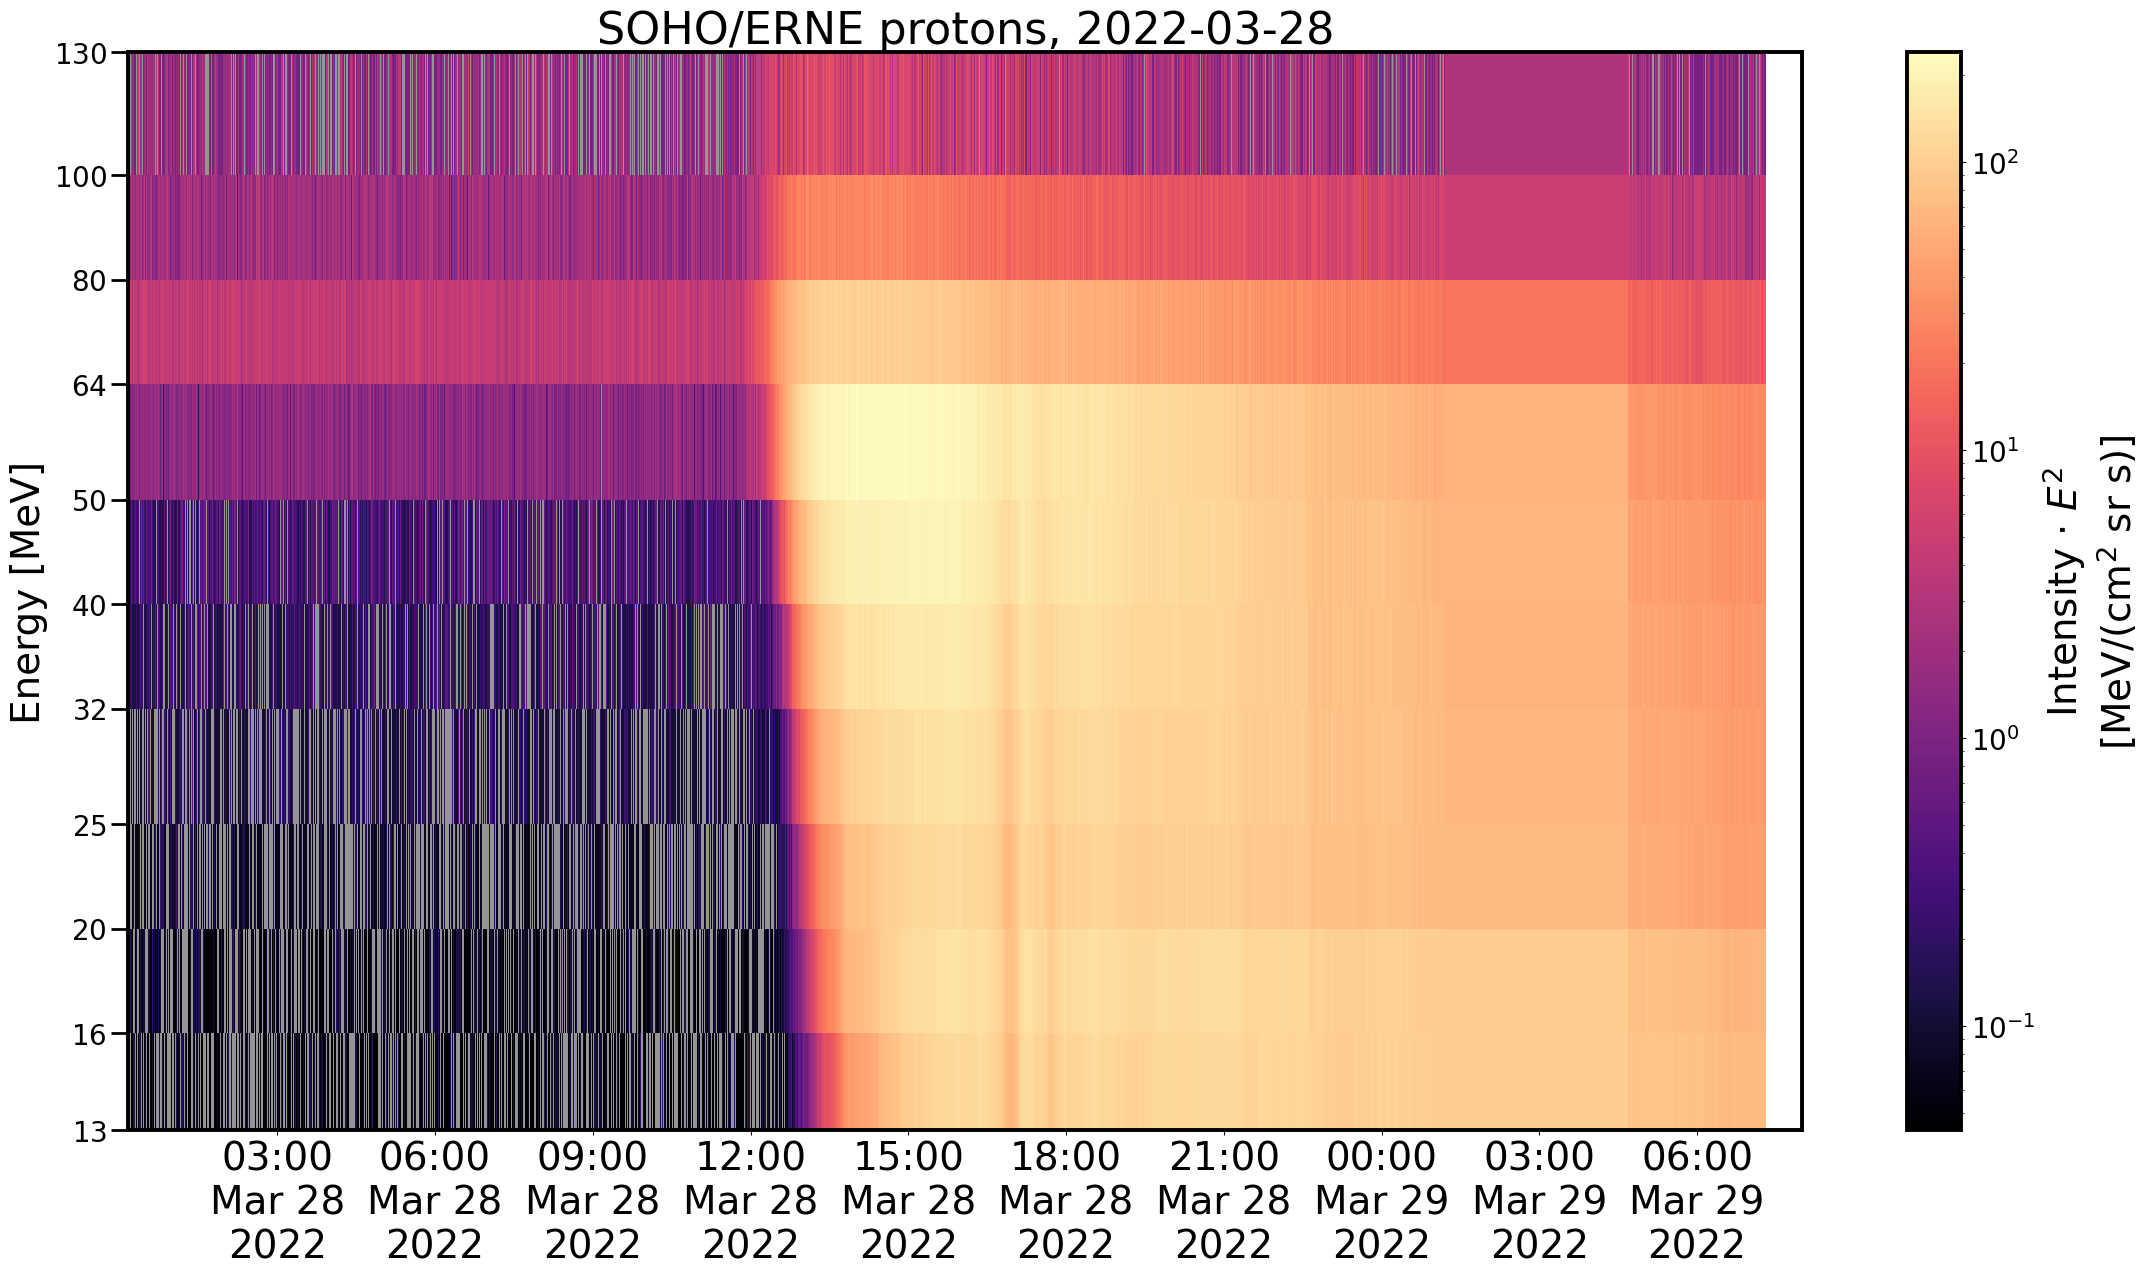

In [7]:
# The horizontal limits (time) of the dynamic spectrum figure
# A pair (either tuple or a list) of pandas-compatible datetime strings
dynamic_spectrum_xlim = ("2022-03-28 00:10", "2022-03-29 08:00")

# A switch to save the figure once created
save_dynamic_spectrum = False

onset.dynamic_spectrum(view=w.view_drop.value,
                      xlim=dynamic_spectrum_xlim,
                      save=save_dynamic_spectrum)

**A note about `plot_range`, `background` and `erase`:**

> The `plot_range` is a list of two pandas-compatible datetime strings, e.g., '2012-12-31 13:37:00', which define the starting and ending position of the plot in the method `cusum_onset()`. If left to None, the entire data loaded into the `Onset` object will be displayed.

> The `background` variable is declared as a `BootstrapWindow` object, which takes input `start` (str), `end` (str) and `bootstraps` (int). `start` and `end` define the starting and ending points of the background as pandas'compatible datetime strings, such as "2023-10-02 13:37:00", while `bootstraps` defines the amount of onsets searched per a distribution.

> The `erase` variable can be used to filter out clearly too high erroneous values from the background. It is a tuple/list of len()==2, that takes as its first entry the maximum allowed intensity value in the background. The second entry is a pandas-compatible datetime string, that defines the ending point of this filter. 

In [8]:
# The channels of any specific instrument can be displayed via print_energies() method
# The type is an integer for all SEPpy missions, but may also be a string for user-defined custom data.
channel = 4

# The limits of the plot, and the limits of the background window.
# Argument 'bootstraps' in the BootstrapWindow object tells the amount of samples taken from the background.
plot_range = ["2022-03-28 08:00", "2022-03-28 18:00:00"]
background = BootstrapWindow(start="2022-03-28 01:00", end="2022-03-28 11:30", bootstraps=1000)

# A filter to erase erroneous values in the background (leave to None if not needed)
erase = None #[3e2, background.end]

# The time averaging, e.g., '2min'. Note that this applies only to the next cell, not to the statistic method.
averaging = "1 min"

# The amount of time, in minutes, that we demand for continuous threshold-exceeding intensity before identifying the onset of the event
cusum_minutes = 30

# The n in the CUSUM function's definition; an integer multiplier of the background standard deviation, that controls the
# sensitivity of the method. A higher multiplier means less sensitive. Default number is 2.
sigma_multiplier = 2

# A save switch for the cusum_onset() plot.
save_quicklook_plot = False

# The quicklook-type method cusum_onset() can use both the classical Poisson-CUSUM, that is designed for integer number
# variables, and the modified Poisson-CUSUM that this software by default runs to z-standardized intensity. 
# 'classic' uses the classical type, and 'modified' uses the modified type. The default is 'modified'.
cusum_type = "modified"

# The diagnostic mode allows for more in-depth look at the event and the determination of the onset time
enable_diagnostic_mode = False

# Finding the event
**If statistical analysis is to be performed, make sure that the background does not overlap with the onset of the event. The cusum_onset() -method works as a convenient quicklook-method to visually examine the event, adjust the background and to get a preliminary estimate of the onset time.**

>The `cusum_onset()` applies the traditional Poisson-CUSUM method to the data, and finds exactly one onset time that corresponds to the
$(\mu,\sigma)$ pair that describes the data point population inside the background. It returns a dictionary of `single_onset_stats` and the `flux_series`, which
is simply the time series that is plotted on the figure. The `single_onset_stats` dictionary includes the mean, mean + n$\cdot$std, the k-parameter (which controls the growth of the cusum function), the h-parameter ('hastiness_threshold', which controls the threshold for the warning signal), the z-standardized intensity time series, the CUSUM function, the onset time and the channel energy value string. 

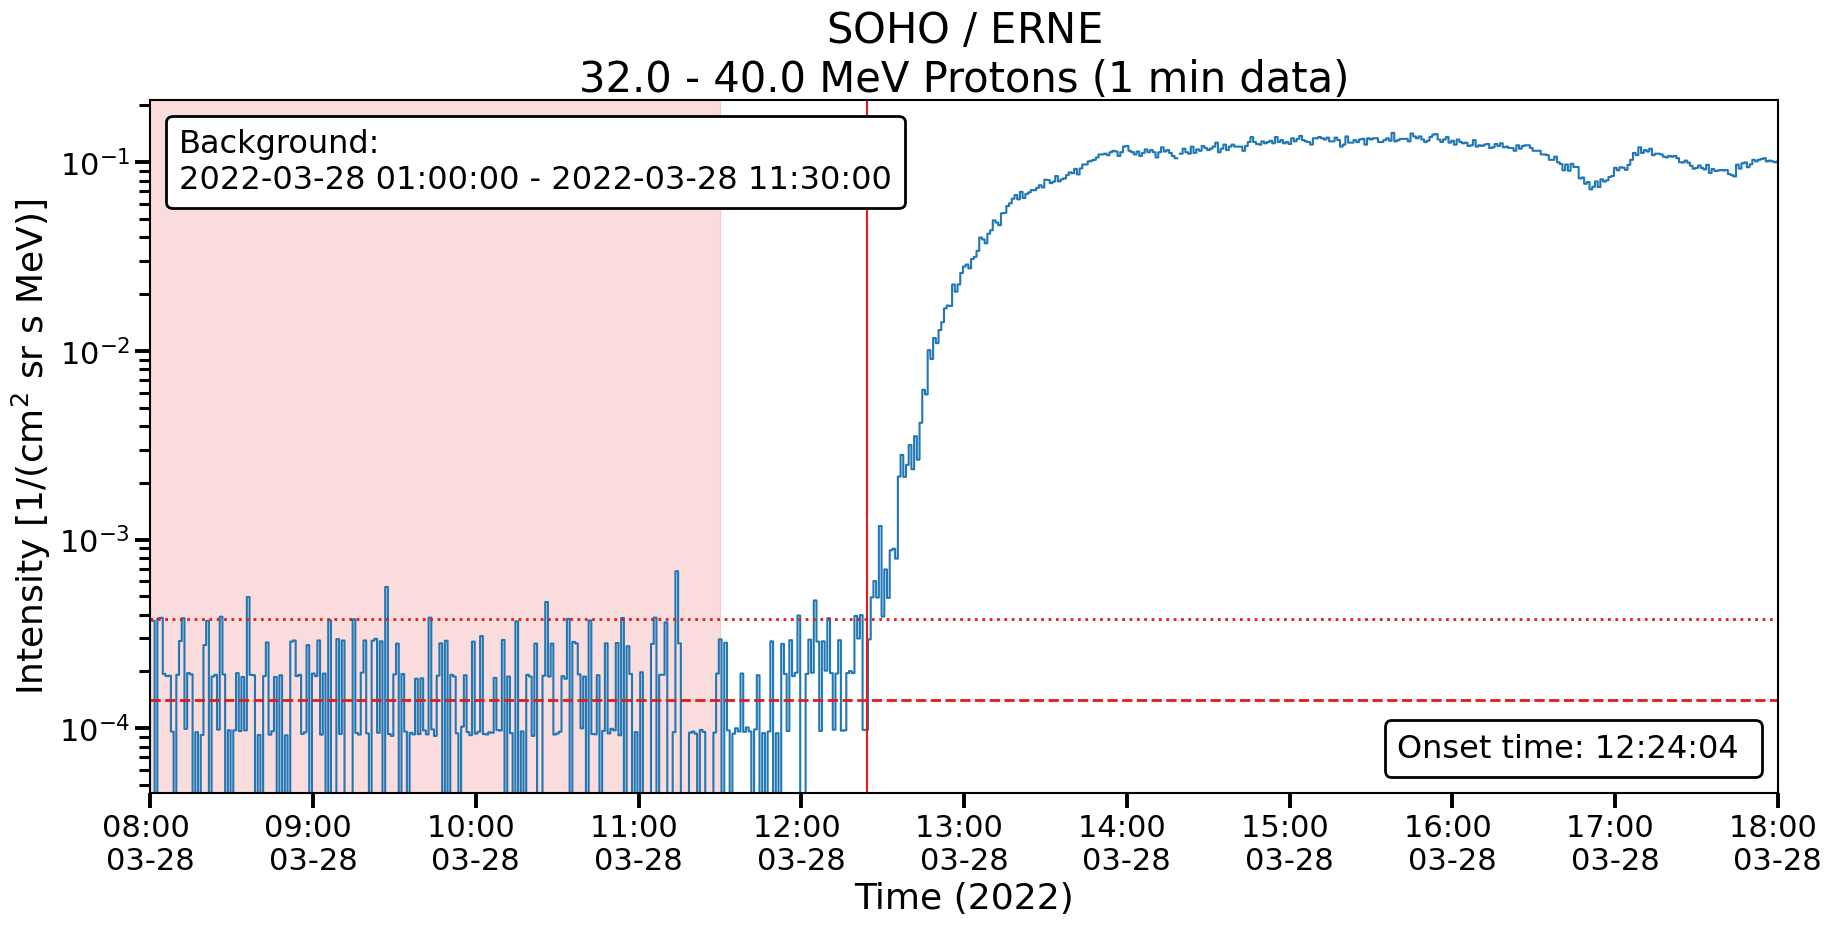

In [9]:
#
single_onset_stats, flux_series = onset.cusum_onset(channels=channel,
                                                    background_range=background,
                                                    xlim=plot_range,
                                                    resample=averaging, 
                                                    erase=erase, 
                                                    cusum_minutes=cusum_minutes,
                                                    sigma_multiplier=sigma_multiplier,
                                                    save=save_quicklook_plot,
                                                    cusum_type=cusum_type,
                                                    diagnostics=enable_diagnostic_mode)

In [10]:
# Calling the single_onset_stats dictionary displays its contents:
single_onset_stats

{'bg_mu': np.float32(0.00014160607),
 'bg_mu_d': np.float32(0.00038007397),
 'k_parameter': np.float32(0.83806),
 'hastiness_threshold': 1,
 'ints_norm': Epoch
 2022-03-28 00:01:04.987     0.035593
 2022-03-28 00:02:04.987    -1.187632
 2022-03-28 00:03:04.987    -0.380815
 2022-03-28 00:04:04.987     0.431034
 2022-03-28 00:05:04.987    -0.411846
                              ...    
 2022-03-29 17:09:04.987    55.926975
 2022-03-29 17:10:04.987    88.551918
 2022-03-29 17:11:04.987    83.519783
 2022-03-29 17:12:04.987    75.636131
 2022-03-29 17:13:04.987    76.139343
 Freq: min, Length: 2473, dtype: float32,
 'cusum': array([0., 0., 0., ..., 0., 0., 0.], shape=(2473,)),
 'onset_time': Timestamp('2022-03-28 12:24:04.987000'),
 'energy_string': '32.0 - 40.0 MeV'}

In [11]:
# This method of the background object suggests the time-averaging to which the method will limit the 
# time-averaging to. 
background.print_max_recommended_reso()

Your chosen background is 630 minutes long. To preserve the minimum of 100 data points to choose from,
it is recommended that you either limit averaging up to 6 minutes or enlarge the background window.


# Acquiring the most likely onset time and its uncertainty
**The cells below perform the statistical Poisson-CUSUM bootstrap hybrid onset evaluation automatically to all available energy channels, and stores the results in the object.**

**About the onset_statistics_per_channel() -method:**

>This method runs the cusum_onset() -method for the native data resolution of the given instrument for the amount of times stated in the `BootstrapWindow` -object's attribute `bootstraps`. From the uncertainty derived from the yielded onset distribution, the method proceeds to average the time series data and produce sets of onset distributions with 1 minute intervals up to that uncertainty in minutes.

>The method can be run for a single channel (int), a list of channels, or to all possible channels by giving `channels='all'` as an input.

>For example: the ~68 % confidence interval of channel X is 10 minutes. The method will proceed to average the time series data up to 10 minutes, creating 10 sets of the same data with progressively coarser time resolution from 1 minute to 10 minutes. Each set will contain a distribution of `bootstraps` amount of onset times, ultimately adding up to `bootstraps` $\cdot$ $\Delta u_{1}^{1}$ individual onset times.

>Ultimately from the sets of distributions created the method calculates a weighted average for the mode, median, ~68 % confidence interval and ~95 % confidence interval for the onset times. These timestamps are stored in the object's dictionary `onset_statistics`, which can be called when the method has been run. If the user should run the method for another channel, this channel's statistics are also saved into this dictionary.

> Note that for Solar Orbiter's and Wind's instruments this method will always average the data to 1 min resolution at the start, unless explicitly told not to with `limit_computation_time=False`, due to the exceptionally fine cadence of the instruments (1 s and 12 s). Limiting computation time also has the effect of producing less distributions past the 10 min time resolution, such that only every 5 minutes integration times are used past 10 minute integration time, i.e., (..8, 9, 10, 15, 20, 25, ...)


The `onset_statistics_per_channel()` method returns a `np.ndarray` that holds `OnsetsStatsArray` objects, one object for each of the channels that the method was run for. Each of these objects, which are stored in `uncertainty_stats_by_channel`, stores the statistics and plots corresponding to their respective channel's sets of distributions.

In [12]:
# The portion of the bootstrap sample that the method randomly picks from the background
sample_size = 0.55

# This switch controls intermediate notification being printed by channelwise_onset_statsistics(), e.g., to which time should the averaging me limited to,
# and which channel is being handled
print_output = True

# An integer number as a seed for the random runmber generator (RNG) that picks the random samples from the chosen
# background. Choosing a random seed ensures replicability of the random process.
random_seed = 101


**About the `OnsetsStatsArray` object:**


`OnsetStatsArray` object's attributes can be listed with the method `.attrs()`. It also has methods to visualize data, such as:

>`.integration_time_plot()`, that shows the mean, median, and mode onsets, and $\sim$68 % and $\sim$95 % confidence intervals corresponding to each distribution of onset times as a function of time resolution.

>`.show_onset_distribution()` displays the full distribution of onset times of a single set marked with vertical lines on the time series data. The most popular onset time (highest frequency in the distribution) is drawn with a solid line, while the rest of the unique onset times are drawn with dashed lines. The less popular onset times appear with a lighter shade than those with higher popularity.

>`.show_onset_statistics()` is very much like the aforementioned method, but instead of the distribution, it displays the mode, median and mean onset times drawn on the time series, accompanied by the $\sim$68 % and $\sim$95 % confidence intervals with a light shading of red and blue, respectively.

In [13]:
# The method below returns a list (with len==1) named uncertainty_stats_per_channel, that holds a single OnsetStatsArray inside it.
# This OnsetStatsArray object holds all the statistics of the onset related to the channel that was previously run.

channel4_uncertainty_statistics = onset.onset_statistics_per_channel(channels=channel, background=background, 
                                                                  erase=erase,
                                                                  cusum_minutes=cusum_minutes, 
                                                                  sample_size=sample_size, 
                                                                  print_output=print_output,
                                                                  random_seed=random_seed)


Your chosen background is 630 minutes long. To preserve the minimum of 100 data points to choose from,
it is recommended that you either limit averaging up to 6 minutes or enlarge the background window.
Channel 4:
~68 % uncertainty for the onset time with native data resolution: 0 days 00:01:00


**In the cell above, the modified Poisson-CUSUM bootstrap hybrid method was applied to the chosen proton channel 1 of the ERNE instrument. The method notified the user of the maximum time-averaging that should and would be applied by the software. Finally the method printed out the width of the middle ~68 percentile of the onset distribution, which is the upper limit for time-averaging.**


`onset_statistics` is a dictionary, that maps each channel number to a list that contains the timestamps: [mean, median, ($\sim$68 % lower bound), ($\sim$68 % upper bound), ($\sim$95 % lower bound), ($\sim$95 % upper bound)]

In [14]:
onset.onset_statistics

{4: [Timestamp('2022-03-28 12:24:00.112000'),
  Timestamp('2022-03-28 12:24:00.112000'),
  Timestamp('2022-03-28 12:23:30.112000'),
  Timestamp('2022-03-28 12:25:00.088499968'),
  Timestamp('2022-03-28 12:19:00.347000'),
  Timestamp('2022-03-28 12:25:00.088499968')]}

# Results
**In the next cell one can visualize the different statistics of the automatic process, such as the uncertainty of the onset as a function of averaging, the distribution of onset times on the time series and the mean, median and mode of the distribution.**

**The statistical information, such as the different distributions for differently time-averaged data, are stored inside the `OnsetStatsArray` objects, which in this example are collected to the numpy array named `uncertainty_stats_by_channel`.**

> The methods `.show_onset_distribution()` and `.show_onset_statistics()` accept the optional arguments `xlim` and `integration_time_index`.

>`xlim` is a pair of pandas-compatible time strings, that define the limits of the x-axis in the plots.

>`integration_time_index` is an integer that defines which of the time-averaged sets of distributions is displayed in the figure. By default, the time series, distribution and statistics for the native data resolution is displayed, which corresponds to `integration_time_index==0`.

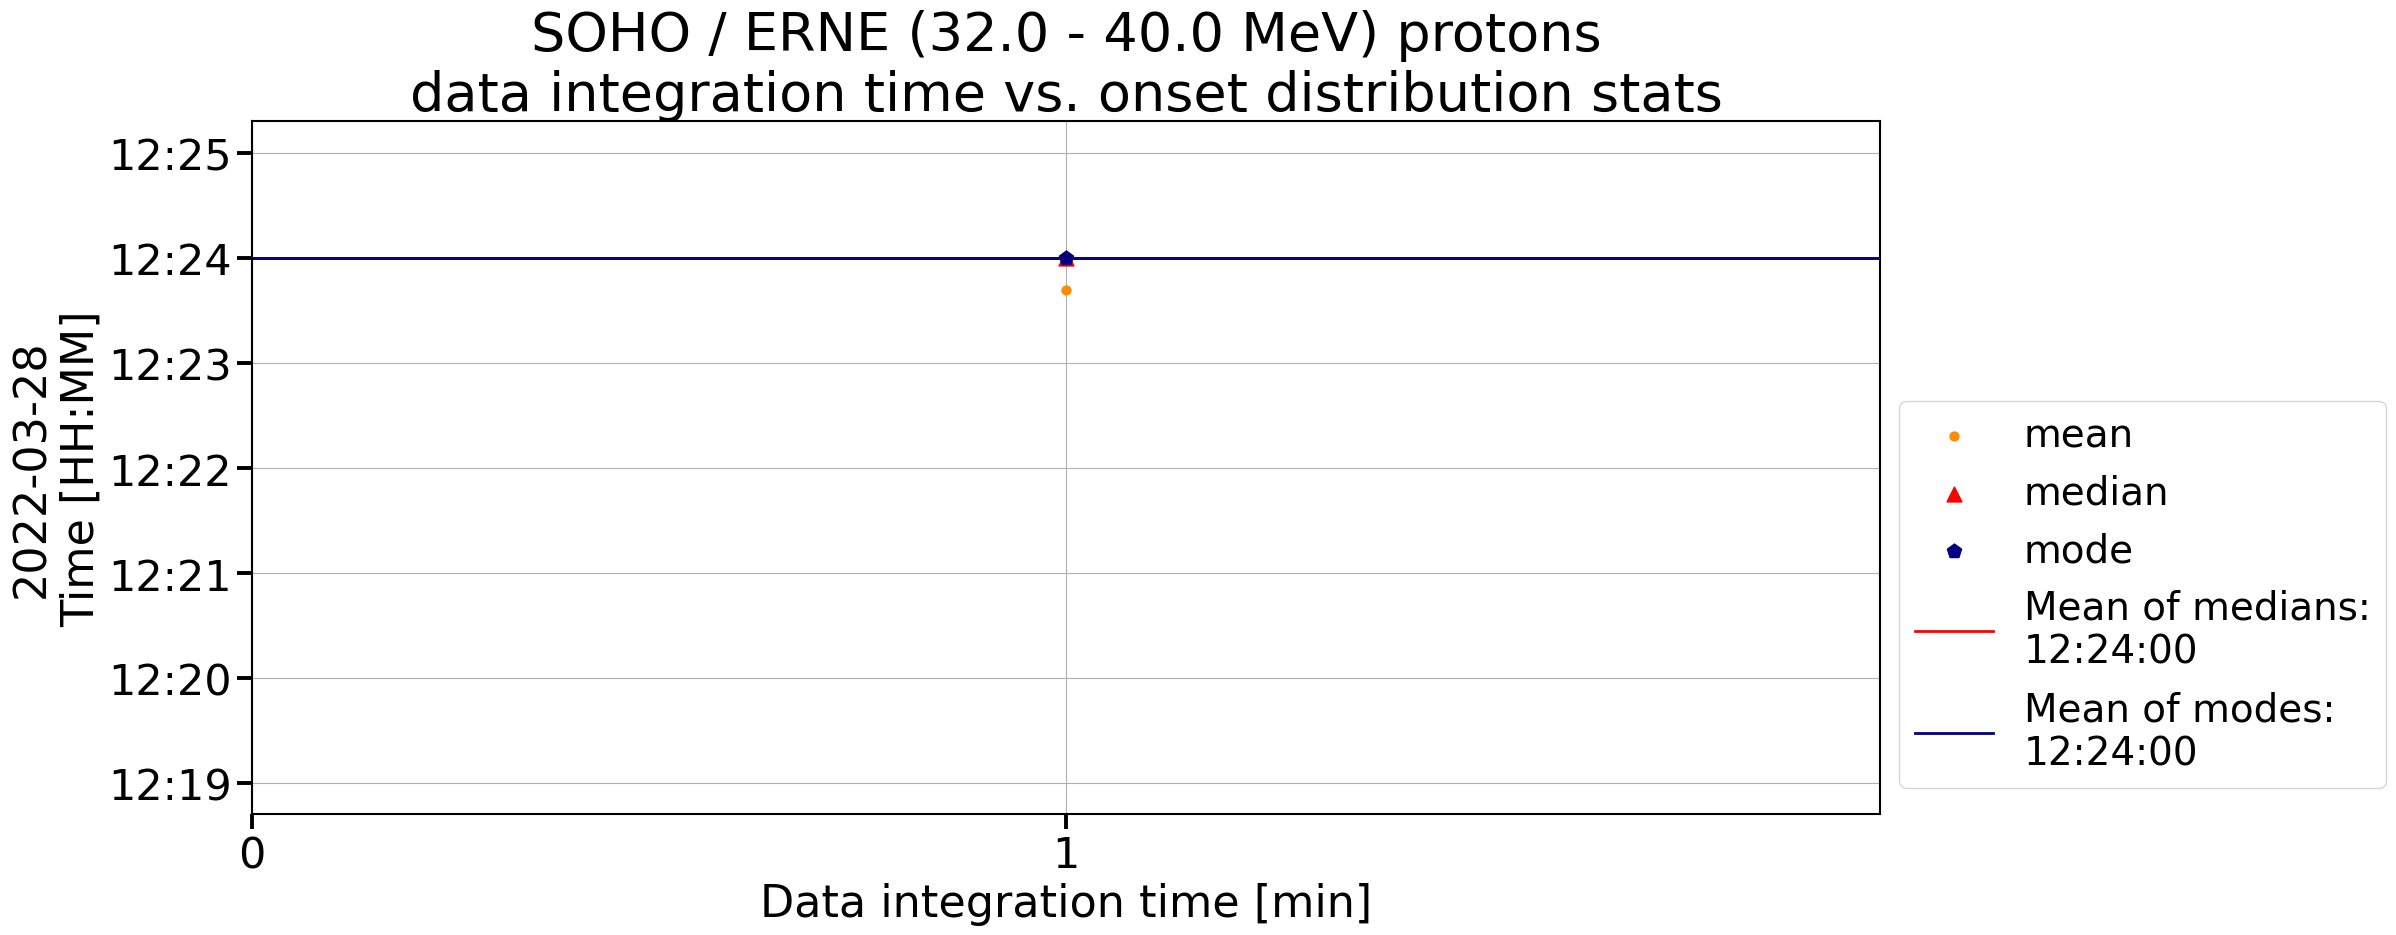

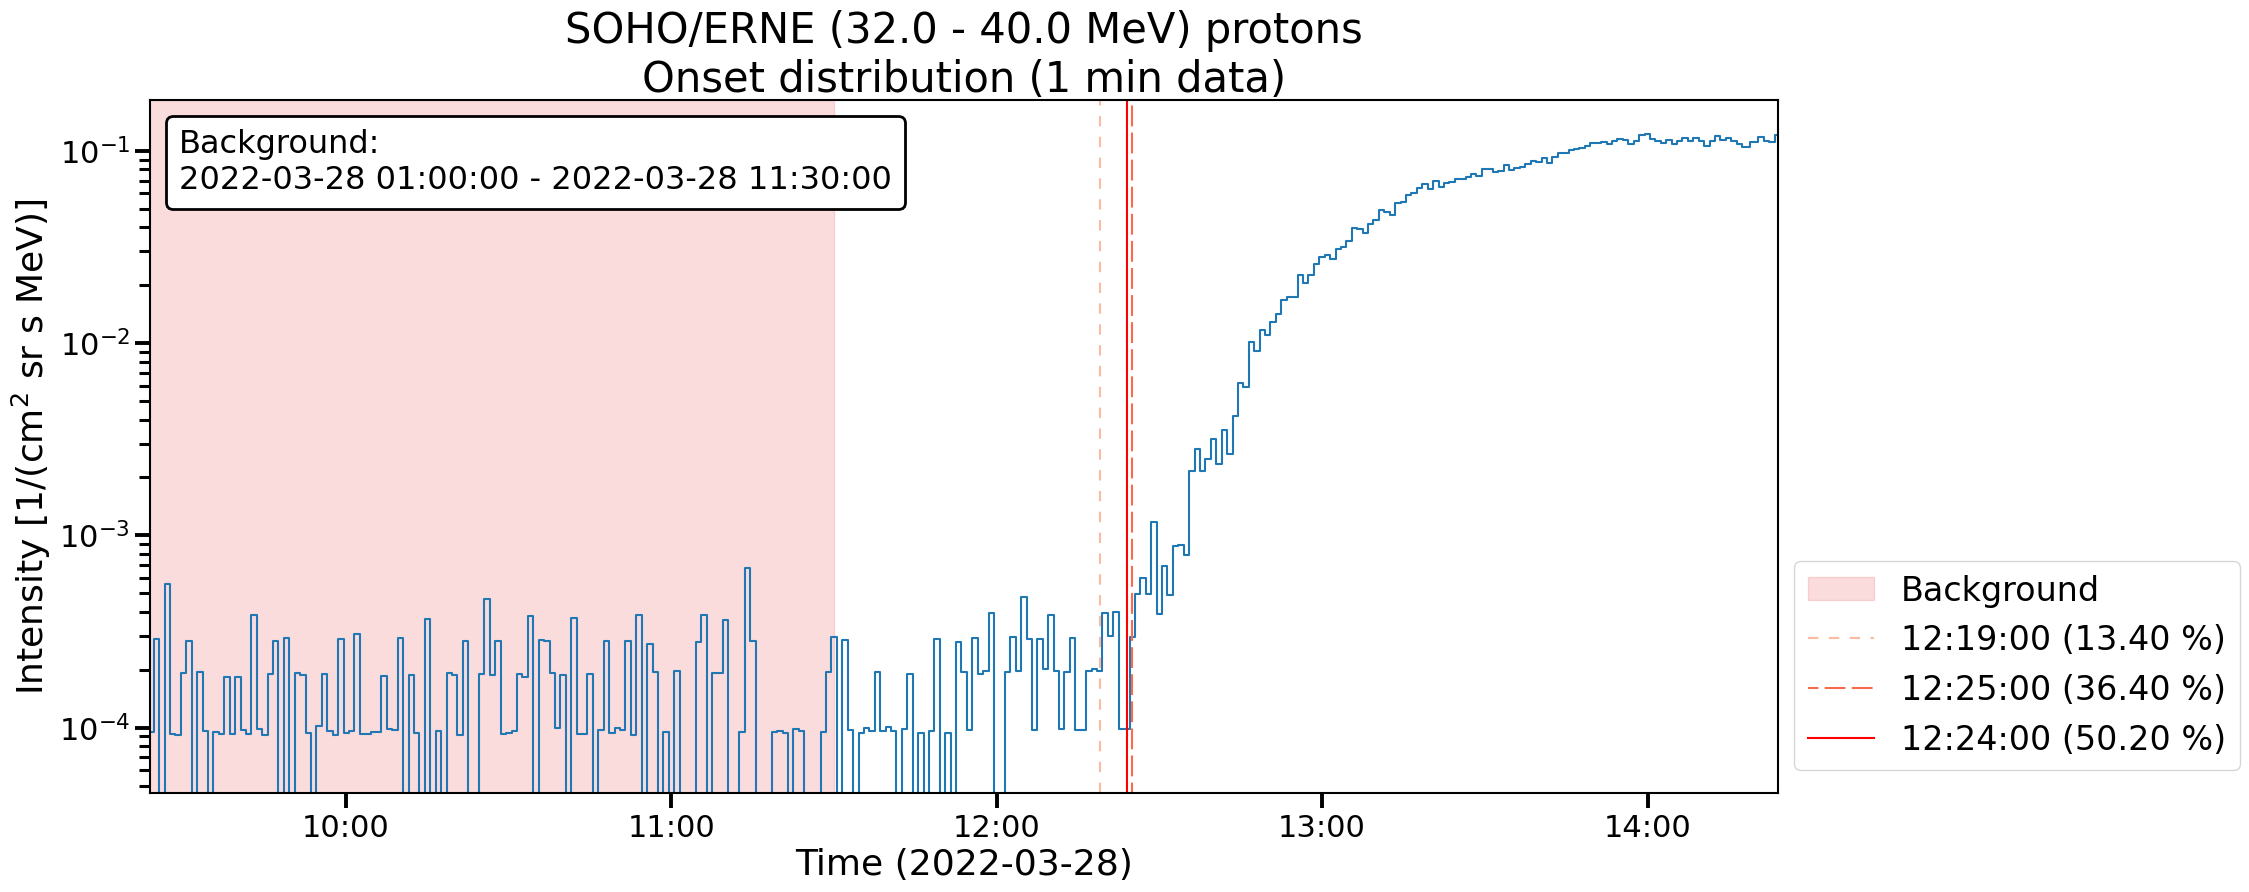

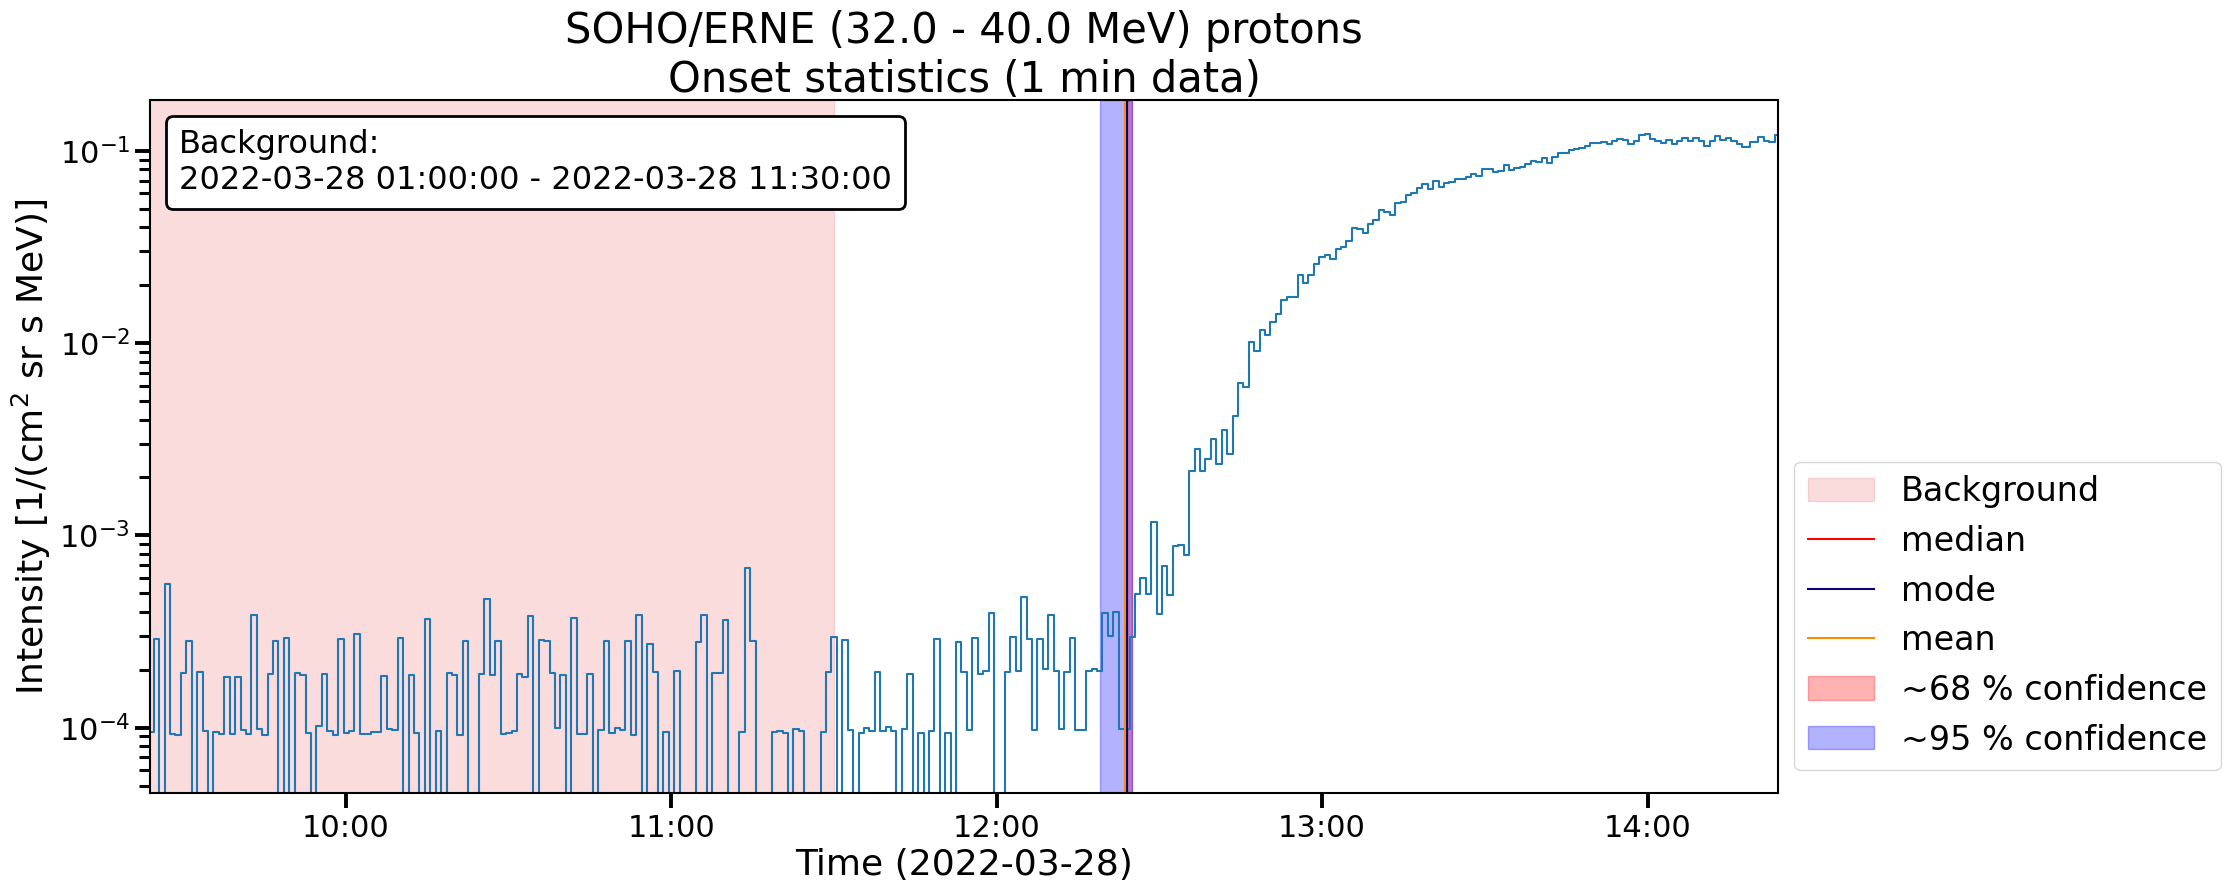

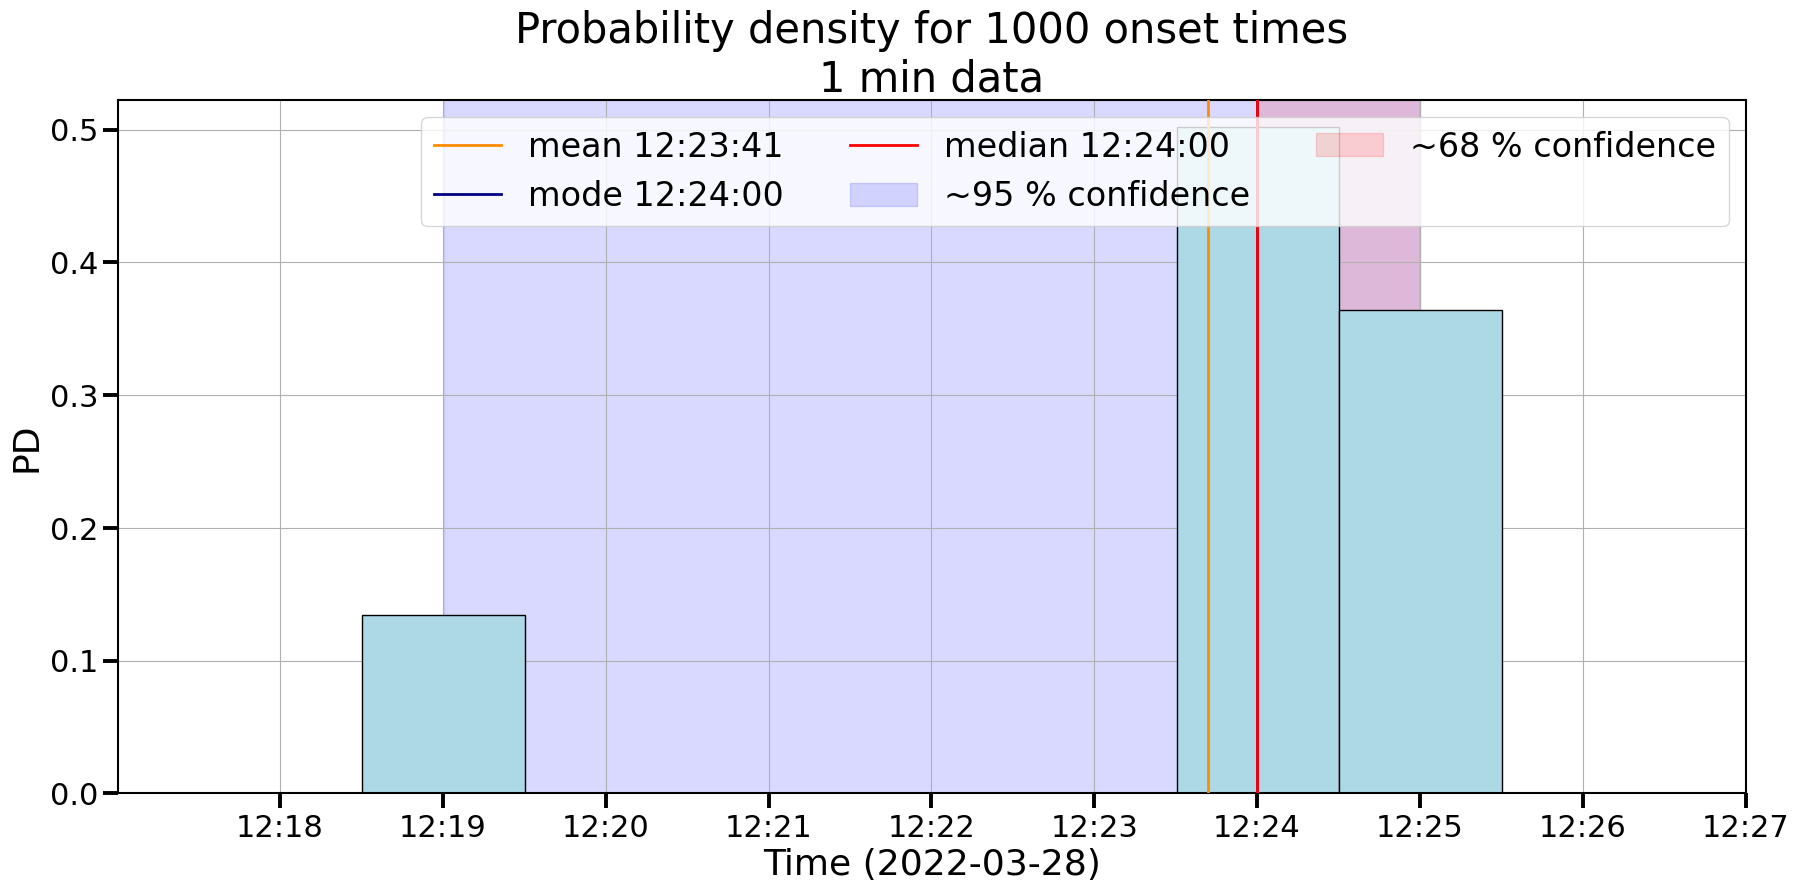

In [15]:
# The index (ordinal number) of the channel in the array
channel_index = 0

channel4_uncertainty_statistics[channel_index].integration_time_plot()
channel4_uncertainty_statistics[channel_index].show_onset_distribution(integration_time_index=0, xlim=None)
channel4_uncertainty_statistics[channel_index].show_onset_statistics(integration_time_index=0, xlim=None)
channel4_uncertainty_statistics[channel_index].onset_time_histogram(integration_time_index=0, xlim=None)

### The `final_onset_plot()` -method of the `Onset` class displays the onset time with uncertainty on the particle time intensity series

**The onset time and the uncertainty displayed on the `onset.final_onset_plot()` are the onset time and the uncertainty determined with the hybrid method, and stored in the dictionary `onset.onset_statistics` (introduced a few cells above).**

> The `onset.final_onset_plot()` -method creates a plot where the onset time + uncertainty found by the hybrid method are drawn over the intensity time series. The selected background can (and by default, will) be drawn on the plot. The plotting method also returns a dictionary of parameters related to the onset time and its determination.

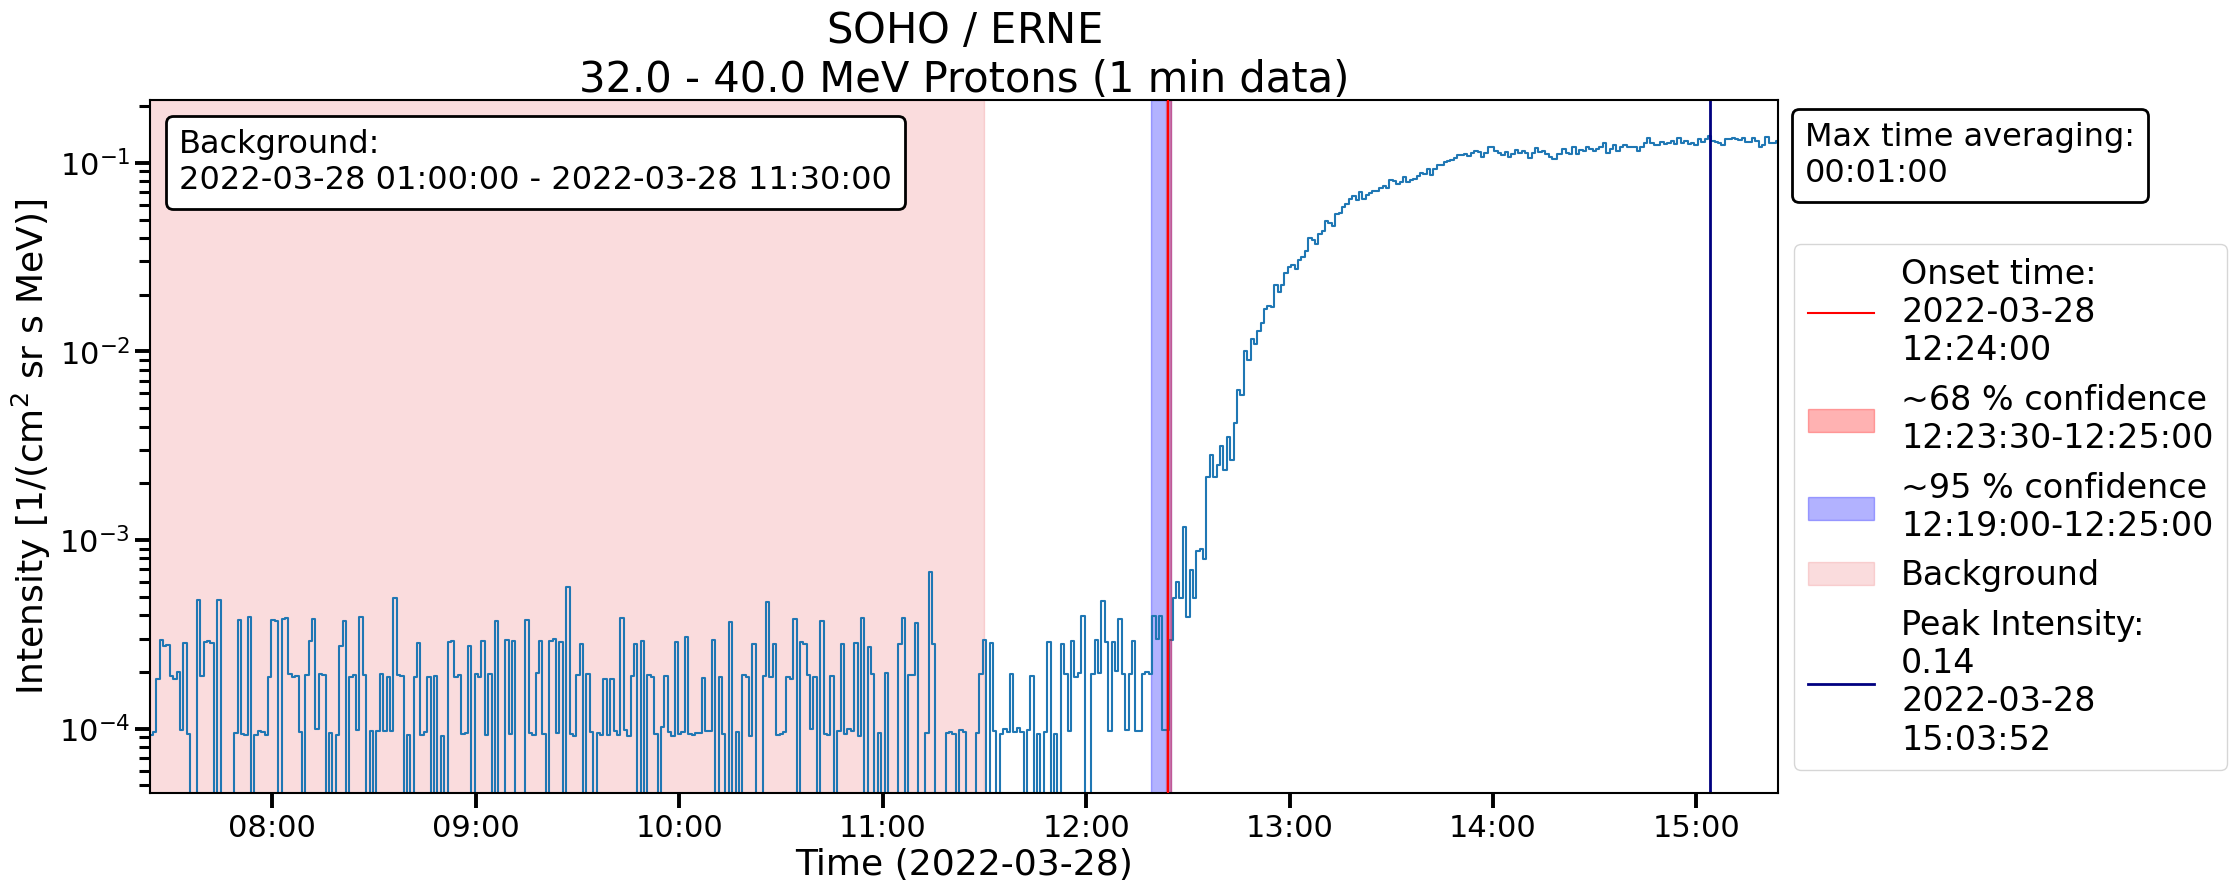

In [16]:
# Final onset plot accepts horizontal limits just like cusum_onset() does. A pair of pandas-compatible
# datetime strings define the left and the right border of the plot. By default the borders of the plot are
# determined by onset time +3/-5 hours
final_plot_xlim = None

# An optional switch to either show the chosen background shading on the plot. The shading is identical
# to how its drawn in cusum_onset() and other plots in this package.
final_plot_background = True

# An optional switch (default False) to also find the peak intensity on the plot and mark it with a vertical
# blue line. The peak intensity and the corresponding timestamp will be displayed on the legend, and added to
# the resulting dictionary that is returned by the method
find_peak = True

# This optional switch (default=False) saves the final onset plot and the accompanying parameters (listed in the
# returned results) in a csv file. The plot and the file have identical names, separated by fileformat.
save_final_plot_and_csv = True

channel4_result = onset.final_onset_plot(channel=channel,
                                         xlim=final_plot_xlim,
                                         show_background=final_plot_background,
                                         peak=find_peak,
                                         save=save_final_plot_and_csv)

In [17]:
# Calling the results dictionary will display its contents
channel4_result

{'onset_time': Timestamp('2022-03-28 12:24:00.112000'),
 'confidence_interval1': [Timestamp('2022-03-28 12:23:30.112000'),
  Timestamp('2022-03-28 12:25:00.088499968')],
 'confidence_interval2': [Timestamp('2022-03-28 12:19:00.347000'),
  Timestamp('2022-03-28 12:25:00.088499968')],
 'sigma_multiplier': 2,
 'max_averaging': Timedelta('0 days 00:01:00'),
 'peak_intensity': np.float32(0.138),
 'peak_time': Timestamp('2022-03-28 15:03:52.612000')}

# The onset time as a function energy

In order to perform velocity dispersion analysis (VDA), we are going to need a range of onset times at different energies. In the next cells we repeat the process above for all available energy channels of this instrument
The `onset_statistics_per_channel()` -method accepts integers, tuples, lists and ranges as an input for the parameter `channels`. Passing the string 'all' as an input runs the method for all available channels in the `Onset` object's memory.

In [18]:
# Run the method with the same input as before, but this time pass channels='all' to repeat 
# the onset time and uncertainty evaluation for all available channels
channels = "all"

uncertainty_stats_by_channel = onset.onset_statistics_per_channel(channels=channels, background=background, 
                                                                  erase=erase,
                                                                  cusum_minutes=cusum_minutes, 
                                                                  sample_size=sample_size, 
                                                                  print_output=print_output)

Your chosen background is 630 minutes long. To preserve the minimum of 100 data points to choose from,
it is recommended that you either limit averaging up to 6 minutes or enlarge the background window.
Channel 0:
~68 % uncertainty for the onset time with native data resolution: 0 days 00:01:00
Channel 1:
~68 % uncertainty for the onset time with native data resolution: 0 days 00:01:00
Channel 2:
~68 % uncertainty for the onset time with native data resolution: 0 days 00:01:00
Channel 3:
~68 % uncertainty for the onset time with native data resolution: 0 days 00:01:00
Channel 4:
~68 % uncertainty for the onset time with native data resolution: 0 days 00:01:00
Channel 5:
~68 % uncertainty for the onset time with native data resolution: 0 days 00:01:00
Channel 6:
~68 % uncertainty for the onset time with native data resolution: 0 days 00:01:00
Channel 7:
~68 % uncertainty for the onset time with native data resolution: 0 days 00:01:00
Channel 8:
~68 % uncertainty for the onset time with 

In [19]:
# The onset_statistics dictionary is automatically updated
onset.onset_statistics

{4: [Timestamp('2022-03-28 12:24:00.112000'),
  Timestamp('2022-03-28 12:24:00.112000'),
  Timestamp('2022-03-28 12:23:30.112000'),
  Timestamp('2022-03-28 12:25:00.088499968'),
  Timestamp('2022-03-28 12:19:00.347000'),
  Timestamp('2022-03-28 12:25:00.088499968')],
 0: [Timestamp('2022-03-28 12:41:59.269000'),
  Timestamp('2022-03-28 12:41:59.269000'),
  Timestamp('2022-03-28 12:41:29.268999936'),
  Timestamp('2022-03-28 12:42:29.269000'),
  Timestamp('2022-03-28 12:41:29.268999936'),
  Timestamp('2022-03-28 12:42:29.269000')],
 1: [Timestamp('2022-03-28 12:33:59.644000'),
  Timestamp('2022-03-28 12:33:59.644000'),
  Timestamp('2022-03-28 12:33:29.644000'),
  Timestamp('2022-03-28 12:34:29.644000'),
  Timestamp('2022-03-28 12:33:29.644000'),
  Timestamp('2022-03-28 12:34:29.644000')],
 2: [Timestamp('2022-03-28 12:29:59.831000'),
  Timestamp('2022-03-28 12:29:59.831000'),
  Timestamp('2022-03-28 12:29:29.831000'),
  Timestamp('2022-03-28 12:30:29.831000064'),
  Timestamp('2022-03-28 

# Velocity Dispersion Analysis (VDA):

**With an onset time and its uncertainty found in varying energy ranges, one can perform velocity dispersion analysis**

>The `.VDA()` -method automatically uses the mode onset times and uncertainties stored in the `Onset` object's memory. It applies a first order polynomial fit using a orthogonal distance regression algorithm to the onset times as a function of the inverse unitless speed $1/\beta = c/v$, where $c$ is the speed of light.

>The method returns a dictionary that holds the values for inverse betas, errors in x and y-directions (energy and time), onset times used, the path length and injection time that the fit yields, the uncertainties related to the path length and injection time, the chi squared of the fit, reason that the ODR algorithm stopped, the figure and its axes.

>The results of analysis are also shown in the legend of the plot, where L is the path length in AUs, and t$_{inj}$ is the common injection time of the observed particles.

/home/chospa/anaconda3/envs/pyonset/lib/python3.12/site-packages/pyonset/datetime_utilities.py:124: UserWarning: Discarding nonzero nanoseconds in conversion.
  dates_in_sec.append((date.to_pydatetime() - datetime.datetime(1970,1,1,0,0,0)).total_seconds())


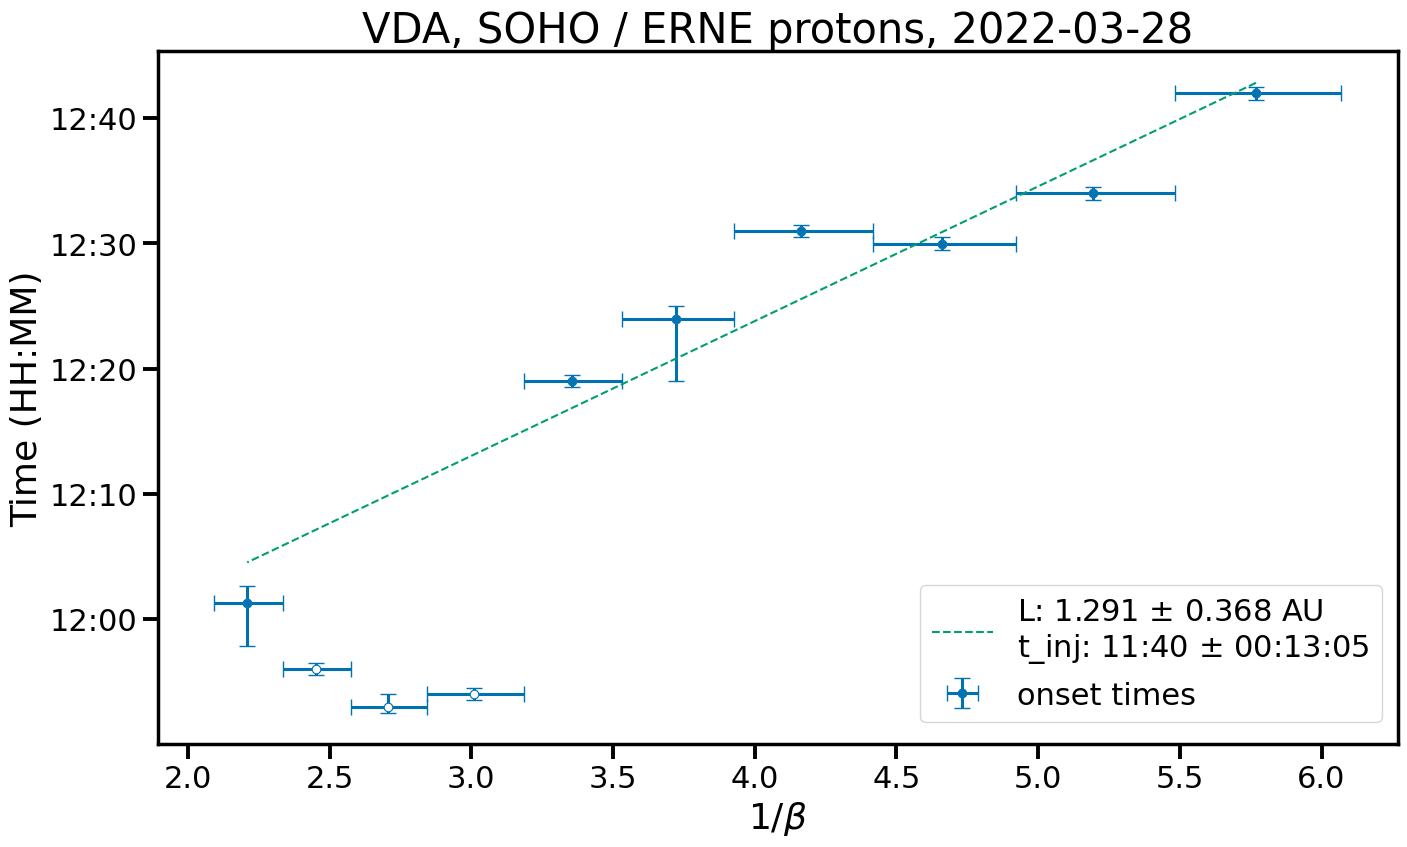

In [20]:
# Not all onset times have to be considered for VDA; an optional selection can be applied on the data points
# either as a python slice object, (which includes data into the selection by index number) or as a list
# of booleans with the same length as the amount of onset times. True onset times are considered to the fit,
# while False onset times are not. Data points not considered to the fit appear hollow in the plot.
selection = slice(0,9)
selection = [True, True, True, True, True, True, False, False, False, True]

# An optional switch to produce a plot of the analysis result
vda_plot = True

# An optional switch to draw a grid on the plot
vda_grid = False

# An optional switch to save the plot
save_vda_plot = False

vda_output = onset.VDA(selection=selection, 
                       plot=vda_plot, 
                       grid=vda_grid, 
                       save=save_vda_plot)

In [21]:
# The output of the .VDA() method is a dictionary that contains the results of analaysis, and everything
# needed to replicate the analysis, e.g., the inverse betas, onset times, selection applied...

# In a familiar way the contents of a dictionary are displayed by calling the dictionary
vda_output

{'inverse_beta': masked_array(data=[5.768937396749051, 5.194021833257364,
                    4.661903645155777, 4.164153705655557,
                    3.723899602074555, 3.353508626888043,
                    3.008412818122867, 2.704728840375989,
                    2.4508109259528035, 2.2088266264888725],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=1e+20),
 'x_errors': masked_array(data=[0.015544175800757287, 0.016161211119595897,
                    0.014502015297598092, 0.015848101588985752,
                    0.011572290754460646, 0.010411735234772568,
                    0.011414947912033568, 0.00836579269618376,
                    0.00755546205890445, 0.009363401561479634],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=1e+20),
 'onset_times': masked_array(data=[Timestamp('2022-03-28 12:41:59.269000'),
        